In [192]:
import pandas as pd
import geopandas
import gmaps
import shapely.geometry as geom
from polygon_geohasher.polygon_geohasher import polygon_to_geohashes, geohashes_to_polygon

%matplotlib inline
import geohash
import geopandas as gp
import pandas as pd
import math
import geojson
from geojson import MultiLineString
from shapely.geometry import MultiLineString
from shapely.geometry import MultiPoint
import numpy as np
from shapely import geometry
from shapely.geometry import Point, Polygon, box,LineString
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry.polygon import LinearRing, Polygon
from numpy import cos,sin,arccos
import numpy as np
from pylab import *
from shapely.ops import cascaded_union
from shapely.geometry import Point, LineString, mapping
import scipy.interpolate
import geopy
import geopy.distance
import time
%autosave 0

Autosave disabled


### Function for preprocessing

In [199]:
def is_geohash_in_bounding_box(current_geohash, bbox_coordinates):
    """Checks if the box of a geohash is inside the bounding box

    :param current_geohash: a geohash
    :param bbox_coordinates: bounding box coordinates
    :return: true if the the center of the geohash is in the bounding box
    """

    coordinates = geohash.decode(current_geohash)
    geohash_in_bounding_box = (bbox_coordinates[0] < coordinates[0] < bbox_coordinates[2]) and (
            bbox_coordinates[1] < coordinates[1] < bbox_coordinates[3])
    return geohash_in_bounding_box
def build_geohash_box(current_geohash):
    """Returns a GeoJSON Polygon for a given geohash

    :param current_geohash: a geohash
    :return: a list representation of th polygon
    """

    b = geohash.bbox(current_geohash)
    polygon = [(b['w'], b['s']), (b['w'], b['n']), (b['e'], b['n']), (b['e'], b['s'],), (b['w'], b['s'])]
    return polygon
def compute_geohash_tiles(bbox_coordinates,GEOHASH_PRECISION):
    """Computes all geohash tile in the given bounding box

    :param bbox_coordinates: the bounding box coordinates of the geohashes
    :return: a list of geohashes
    """

    checked_geohashes = set()
    geohash_stack = set()
    geohashes = []
    # get center of bounding box, assuming the earth is flat ;)
    center_latitude = (bbox_coordinates[0] + bbox_coordinates[2]) / 2
    center_longitude = (bbox_coordinates[1] + bbox_coordinates[3]) / 2

    center_geohash = geohash.encode(center_latitude, center_longitude, precision=GEOHASH_PRECISION)
    geohashes.append(center_geohash)
    geohash_stack.add(center_geohash)
    checked_geohashes.add(center_geohash)
    while len(geohash_stack) > 0:
        current_geohash = geohash_stack.pop()
        neighbors = geohash.neighbors(current_geohash)
        for neighbor in neighbors:
            if neighbor not in checked_geohashes and is_geohash_in_bounding_box(neighbor, bbox_coordinates):
                geohashes.append(neighbor)
                geohash_stack.add(neighbor)
                checked_geohashes.add(neighbor)
    return geohashes
def create_polygon(coordinates):
    polygon_geom = Polygon(coordinates)
    crs = {'init': 'epsg:4326'}
    polygon = gp.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])     
    return polygon.geometry # return polygon['geometry']
# this function is for save the geohashes into a json file 
def write_geohash_layer(geohashes,filename):
    """Writes a grid layer based on the geohashes

    :param geohashes: a list of geohashes
    """

    layer = MultiLineString([build_geohash_box(gh) for gh in geohashes])
    with open('result/' + filename + '.json', 'wb') as f:
        f.write(geojson.dumps(layer,sort_keys=True).encode('utf-8'))

def compute_geohash_tiles_from_polygon(polygon,GEOHASH_PRECISION, name):
    """Computes all hex tile in the given polygon

    :param polygon: the polygon
    :return: a list of geohashes
    """
    print(name)
    start = time.time()
    current = 0
    checked_geohashes = set()
    geohash_stack = set()
    geohashes = []
    # get center of bounding, assuming the earth is flat ;)
    
    #center_latitude = polygon.centroid.coords[0][0]
    #center_longitude = polygon.centroid.coords[0][1]
    
    center_latitude = polygon.centroid.coords[0][1]
    center_longitude = polygon.centroid.coords[0][0]

    center_geohash = geohash.encode(center_latitude, center_longitude, precision=GEOHASH_PRECISION)
    geohashes.append(center_geohash)
    geohash_stack.add(center_geohash)
    checked_geohashes.add(center_geohash)
    while len(geohash_stack) > 0 and current < 5:
        current = time.time() - start
        current_geohash = geohash_stack.pop()
        neighbors = geohash.neighbors(current_geohash)
        for neighbor in neighbors:
            point = geometry.Point(geohash.decode(neighbor)[::-1])
            if neighbor not in checked_geohashes and polygon.contains(point):
                geohashes.append(neighbor)
                geohash_stack.add(neighbor)
                checked_geohashes.add(neighbor)
    return geohashes

def getNewDistance(lat1,lon1,degree,radius):
    R = 6378.1 #Radius of the Earth
    brng = math.radians(degree) #Bearing is 90 degrees converted to radians.
    d = radius #Distance in km

    #lat2  52.20444 - the lat result I'm hoping for
    #lon2  0.36056 - the long result I'm hoping for.

    lat1 = math.radians(lat1) #Current lat point converted to radians
    lon1 = math.radians(lon1) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1), math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    print(lat2)
    print(lon2)
    return lat2,lon2


def getDistance(lat1, long1, distance, bearing):
    
    try:
        # Define starting point.
        start = geopy.Point(lat1, long1)

        # Define a general distance object, initialized with a distance of 1 km.
        d = geopy.distance.VincentyDistance(kilometers = distance)

        # Use the `destination` method with a bearing of 0 degrees (which is north)
        # in order to go from point `start` 1 km to north.
        #print d.destination(point=start, bearing=0)
        return d.destination(point=start,bearing=bearing)
    except:
        pass

def quadraticpolygon(c,a,b):
    try:
        a = list(a)
        b = list(b)
        c = list(c)
        coords = np.array([a,b,c])
        f = scipy.interpolate.interp1d(coords[:, 0], coords[:, 1],kind='quadratic') #, kind='quadratic'
        fine_x = np.linspace(np.min(coords[:, 0]), np.max(coords[:, 0]),20)
        fine_y = f(fine_x)
        fine_coords = zip(fine_x, fine_y)
        #fine_line = LineString(fine_coords)
        myshape = geometry.Polygon(fine_coords)
        return myshape
    except:
        pass

    
def generatePolygon(lat1, long1, radius, angle1, angle2):
    import geopandas as gpd
    from shapely.geometry import Polygon
    lat_point_list = []
    lon_point_list = []
    point1 = getDistance(lat1, long1, radius, angle1)
    point2 = getDistance(lat1, long1, radius, angle2)
    
    point1_lat = point1[0]
    point1_lon = point1[1]
    
    point2_lat = point2[0]
    point2_lon = point2[1]
    
    lat_point_list.append(lat1)
    lat_point_list.append(point1_lat)
    lat_point_list.append(point2_lat)
    
    lon_point_list.append(long1)
    lon_point_list.append(point1_lon)
    lon_point_list.append(point2_lon)
    
    polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
    crs = {'init': 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
    #print(polygon.geometry)
    
    return polygon.geometry
    
    
    

In [200]:
# Reading of files

cell_df = pd.read_csv("datathon.cell.details.csv", encoding="ISO-8859-1")
cx_df = pd.read_csv("datathon.cx.event.hourly.summary.wout.attributes.csv", encoding="ISO-8859-1")
mobilewalle_df = pd.read_csv("datathon.mobilewalla.csv", encoding="ISO-8859-1")
retailer_df = pd.read_excel("datathon.retailer.locations.xlsx")

# Retarded json but put csv

#mydialog_df = pd.read_csv("datathon.mydialog.app.csv", encoding="utf-8")
my_dialog_f = open('datathon.mydialog.app.csv', 'r')

#for line in my_dialog_f:
    
    #print(line)
    #line = line.split('|')
    #print(line[0], 'line0')
    #print(line[1], 'line1')
    #print(line[2], 'line2')





In [211]:
cell_df.head()

,SITE_ID,LOCATION_ID,CELL_NAME,TECHNOLOGY,TYPE,CELL_ID,LATITUDE,LONGITUDE,AZIMUTH,ANTENNA_HEIGHT,ALTITUDE,BEAMWIDTH,CELL_RADIUS,angle1,angle2
29129,UCM0035,CM0035,Kaduwela-CM0035-U_2B,3G,Outdoor,1001.0,6.932777,79.984444,100.0,50.0,31.36,32.93405,3.2,130.0,70.0
30206,UCM0035,CM0035,Kaduwela-CM0035-U_2P,3G,Outdoor,1002.0,6.932777,79.984444,0.0,50.0,31.36,32.7159081,2.7,30.0,-30.0
30549,UCM0035,CM0035,Kaduwela-CM0035-U_2Q,3G,Outdoor,1003.0,6.932777,79.984444,100.0,50.0,31.36,32.93405,3.2,130.0,70.0
28065,UCM0035,CM0035,Kaduwela-CM0035-U_1W,3G,Outdoor,1004.0,6.932777,79.984444,200.0,50.0,31.36,33.586647,1.0,230.0,170.0
29402,UGM0044,GM0044,Thihariya-GM0044-U_2B,3G,Outdoor,1014.0,7.125000,80.069722,140.0,27.0,36.84,32.598484,2.7,170.0,110.0


In [202]:
cell_df = cell_df[cell_df.AZIMUTH != 'No Planet ']
cell_df['AZIMUTH'] = cell_df['AZIMUTH'].astype(float)
cell_df['angle1'] = cell_df['AZIMUTH'] + 30
cell_df['angle2'] = cell_df['AZIMUTH'] - 30

cell_df = cell_df[cell_df.CELL_RADIUS != '¿3000']
cell_df = cell_df[cell_df.CELL_RADIUS != '2000m']
cell_df['CELL_RADIUS'] = cell_df['CELL_RADIUS'].astype(float)
cell_df['CELL_RADIUS'] = cell_df['CELL_RADIUS']/1000

cell_df = cell_df[cell_df.LATITUDE != 'No Planet Data']
cell_df['LATITUDE'] = cell_df['LATITUDE'].astype(float)
cell_df['LONGITUDE'] = cell_df['LONGITUDE'].astype(float)

cell_df['CELL_ID'] = cell_df['CELL_ID'].astype(float)
cell_df = cell_df[cell_df['CELL_ID'] > 1000]

cell_df = cell_df[cell_df['LATITUDE'] > 6.638906]
cell_df = cell_df[cell_df['LATITUDE'] < 7.158444]

cell_df = cell_df[cell_df['LONGITUDE'] > 79.698579]
cell_df = cell_df[cell_df['LONGITUDE'] < 80.118589]



cell_df = cell_df.dropna()


In [203]:
cell_df.head()
groups = cell_df.groupby('CELL_ID')
print(cell_df['CELL_ID'].nunique())
#print(cell_df['CELL_ID'].unique().count())
#len(cell_df)

11970


In [210]:
print(len(cell_df))

11970


In [205]:
cell_df = cell_df.sort_values(by='CELL_ID')

In [212]:
cell_df['polygon'] = cell_df.apply(lambda x: generatePolygon(x.LATITUDE,
                                                               x.LONGITUDE,
                                                               x.CELL_RADIUS,
                                                               x.angle1,
                                                               x.angle2), axis=1)




C:\Users\AC408\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:132: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


In [213]:
test_df = cell_df.head(10)
start = time.time()
test_df['geohash_set'] = test_df.apply(lambda x: compute_geohash_tiles_from_polygon(x.polygon, 7, x.CELL_ID), axis=1)
end = time.time()

print(end-start)
test_df.head()

1001.0
1002.0
1003.0
1004.0
1014.0
1015.0
1016.0
1018.0
1019.0
1020.0
0.40032529830932617


C:\Users\AC408\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SITE_ID,LOCATION_ID,CELL_NAME,TECHNOLOGY,TYPE,CELL_ID,LATITUDE,LONGITUDE,AZIMUTH,ANTENNA_HEIGHT,ALTITUDE,BEAMWIDTH,CELL_RADIUS,angle1,angle2,polygon,geohash_set
29129,UCM0035,CM0035,Kaduwela-CM0035-U_2B,3G,Outdoor,1001.0,6.932777,79.984444,100.0,50.0,31.36,32.93405,3.2,130.0,70.0,"POLYGON ((79.984444 6.932777, 80.0066250228350...","[tc0zkmw, tc0zkmt, tc0zkmx, tc0zkmq, tc0zkmm, ..."
30206,UCM0035,CM0035,Kaduwela-CM0035-U_2P,3G,Outdoor,1002.0,6.932777,79.984444,0.0,50.0,31.36,32.7159081,2.7,30.0,-30.0,"POLYGON ((79.984444 6.932777, 79.9966605277349...","[tc0zs0d, tc0zs09, tc0zs0e, tc0zs06, tc0zs03, ..."
30549,UCM0035,CM0035,Kaduwela-CM0035-U_2Q,3G,Outdoor,1003.0,6.932777,79.984444,100.0,50.0,31.36,32.93405,3.2,130.0,70.0,"POLYGON ((79.984444 6.932777, 80.0066250228350...","[tc0zkmw, tc0zkmt, tc0zkmx, tc0zkmq, tc0zkmm, ..."
28065,UCM0035,CM0035,Kaduwela-CM0035-U_1W,3G,Outdoor,1004.0,6.932777,79.984444,200.0,50.0,31.36,33.586647,1.0,230.0,170.0,"POLYGON ((79.984444 6.932777, 79.9775122437192...","[tc0zkj1, tc0zkj0, tc0zkj4, tc0zkhc, tc0zkhb, ..."
29402,UGM0044,GM0044,Thihariya-GM0044-U_2B,3G,Outdoor,1014.0,7.125000,80.069722,140.0,27.0,36.84,32.598484,2.7,170.0,110.0,"POLYGON ((80.069722 7.125, 80.073966089065 7.1...","[tc2bqpp, tc2bqpn, tc2bqr0, tc2bqnz, tc2bqny, ..."


In [214]:
cell_df['geohash_set'] = cell_df.apply(lambda x: compute_geohash_tiles_from_polygon(x.polygon, 7, x.CELL_ID), axis=1)

1001.0
1002.0
1003.0
1004.0
1014.0
1015.0
1016.0
1018.0
1019.0
1020.0
1021.0
1022.0
1023.0
1024.0
1025.0
1026.0
1028.0
1029.0
1031.0
1032.0
1034.0
1055.0
1056.0
1057.0
1058.0
1059.0
1060.0
1061.0
1062.0
1063.0
1064.0
1065.0
1066.0
1067.0
1068.0
1072.0
1073.0
1074.0
1075.0
1076.0
1077.0
1078.0
1079.0
1086.0
1087.0
1088.0
1089.0
1090.0
1092.0
1093.0
1094.0
1095.0
1096.0
1097.0
1099.0
1100.0
1101.0
1102.0
1103.0
1104.0
1156.0
1157.0
1158.0
1160.0
1162.0
1164.0
1165.0
1166.0
1167.0
1170.0
1173.0
1174.0
1176.0
1178.0
1179.0
1180.0
1204.0
1205.0
1206.0
1207.0
1208.0
1209.0
1210.0
1211.0
1215.0
1216.0
1218.0
1225.0
1226.0
1240.0
1245.0
1246.0
1248.0
1260.0
1261.0
1265.0
1266.0
1267.0
1268.0
1269.0
1270.0
1272.0
1278.0
1279.0
1280.0
1281.0
1282.0
1284.0
1286.0
1288.0
1297.0
1298.0
1307.0
1378.0
1379.0
1380.0
1381.0
1382.0
1383.0
1463.0
1488.0
1489.0
1490.0
1491.0
1492.0
1493.0
1495.0
1498.0
1499.0
1500.0
1501.0
1509.0
1510.0
1511.0
1515.0
1516.0
1517.0
1522.0
1527.0
1528.0
1574.0
1635.0
1637.0

6208.0
6209.0
6210.0
6226.0
6227.0
6228.0
6229.0
6230.0
6231.0
6283.0
6314.0
6315.0
6383.0
6386.0
6389.0
6390.0
6401.0
6403.0
6404.0
6405.0
6406.0
6407.0
6414.0
6415.0
6416.0
6417.0
6418.0
6419.0
6420.0
6421.0
6422.0
6423.0
6424.0
6425.0
6426.0
6427.0
6428.0
6429.0
6430.0
6432.0
6433.0
6434.0
6435.0
6436.0
6437.0
6438.0
6439.0
6440.0
6441.0
6442.0
6443.0
6444.0
6445.0
6446.0
6447.0
6448.0
6449.0
6450.0
6451.0
6459.0
6460.0
6461.0
6462.0
6463.0
6466.0
6467.0
6468.0
6469.0
6470.0
6471.0
6472.0
6473.0
6477.0
6478.0
6479.0
6485.0
6486.0
6487.0
6488.0
6489.0
6490.0
6491.0
6492.0
6493.0
6494.0
6495.0
6496.0
6497.0
6498.0
6499.0
6500.0
6501.0
6502.0
6503.0
6504.0
6505.0
6506.0
6507.0
6508.0
6509.0
6510.0
6511.0
6512.0
6513.0
6514.0
6515.0
6516.0
6517.0
6518.0
6519.0
6520.0
6521.0
6522.0
6525.0
6526.0
6527.0
6533.0
6534.0
6535.0
6536.0
6537.0
6538.0
6539.0
6540.0
6542.0
6543.0
6544.0
6545.0
6546.0
6547.0
6550.0
6551.0
6569.0
6570.0
6601.0
6617.0
6618.0
6625.0
6626.0
6627.0
6634.0
6635.0
6636.0

12647.0
12648.0
12649.0
12650.0
12651.0
12652.0
12653.0
12654.0
12655.0
12656.0
12657.0
12658.0
12659.0
12660.0
12661.0
12662.0
12663.0
12664.0
12665.0
12666.0
12667.0
12668.0
12669.0
12670.0
12671.0
12672.0
12694.0
12695.0
12696.0
12697.0
12726.0
12727.0
12728.0
12729.0
12730.0
12731.0
12732.0
12733.0
12734.0
12735.0
12745.0
12746.0
12747.0
12748.0
12749.0
12803.0
12804.0
12805.0
12807.0
12808.0
12809.0
12810.0
12813.0
12814.0
12815.0
12816.0
12817.0
12818.0
12819.0
12820.0
12821.0
12823.0
12824.0
12825.0
12826.0
12827.0
12828.0
12829.0
12830.0
12835.0
12836.0
12840.0
12841.0
12842.0
12843.0
12844.0
12845.0
12852.0
12853.0
12854.0
12856.0
12857.0
12858.0
12859.0
12860.0
12861.0
12883.0
12884.0
12885.0
12889.0
12890.0
12891.0
12900.0
12901.0
12902.0
12903.0
12904.0
12905.0
12906.0
12907.0
12908.0
12909.0
12910.0
12911.0
12912.0
12913.0
12914.0
12915.0
12916.0
12917.0
12918.0
12919.0
12920.0
12927.0
12928.0
12929.0
12944.0
12945.0
12946.0
12947.0
12948.0
12949.0
12950.0
12951.0
12952.0


19320.0
19321.0
19322.0
19323.0
19324.0
19325.0
19329.0
19330.0
19331.0
19343.0
19344.0
19345.0
19352.0
19353.0
19354.0
19355.0
19358.0
19359.0
19360.0
19361.0
19362.0
19363.0
19364.0
19365.0
19366.0
19367.0
19368.0
19369.0
19370.0
19371.0
19372.0
19373.0
19377.0
19378.0
19379.0
19380.0
19381.0
19382.0
19383.0
19384.0
19385.0
19391.0
19392.0
19401.0
19402.0
19403.0
19404.0
19405.0
19406.0
19409.0
19410.0
19411.0
19415.0
19416.0
19417.0
19418.0
19419.0
19420.0
19421.0
19422.0
19423.0
19425.0
19426.0
19427.0
19428.0
19429.0
19430.0
19431.0
19432.0
19433.0
19437.0
19438.0
19439.0
19440.0
19441.0
19442.0
19449.0
19450.0
19454.0
19484.0
19485.0
19486.0
19487.0
19488.0
19489.0
19490.0
19491.0
19492.0
19493.0
19494.0
19495.0
19504.0
19505.0
19506.0
19510.0
19512.0
19513.0
19514.0
19515.0
19516.0
19517.0
19518.0
19519.0
19520.0
19521.0
19522.0
19523.0
19524.0
19525.0
19526.0
19527.0
19528.0
19535.0
19536.0
19537.0
19538.0
19539.0
19540.0
19550.0
19551.0
19552.0
19553.0
19555.0
19556.0
19557.0


27254.0
27255.0
27256.0
27257.0
27258.0
27259.0
27260.0
27261.0
27262.0
27263.0
27264.0
27265.0
27268.0
27269.0
27270.0
27271.0
27278.0
27279.0
27280.0
27281.0
27282.0
27283.0
27284.0
27290.0
27291.0
27294.0
27295.0
27296.0
27297.0
27298.0
27299.0
27302.0
27303.0
27305.0
27306.0
27307.0
27308.0
27309.0
27310.0
27311.0
27312.0
27322.0
27323.0
27324.0
27328.0
27329.0
27333.0
27334.0
27351.0
27352.0
27353.0
27356.0
27357.0
27358.0
27879.0
27902.0
27966.0
27967.0
28058.0
28059.0
28060.0
28061.0
28066.0
28067.0
28072.0
28073.0
28074.0
28075.0
28538.0
28539.0
28540.0
28541.0
28542.0
28543.0
28546.0
28547.0
28548.0
28549.0
28550.0
28551.0
28552.0
28553.0
28554.0
28555.0
28556.0
28557.0
28558.0
28559.0
28560.0
28561.0
28562.0
28563.0
28564.0
28565.0
28568.0
28569.0
28570.0
28571.0
28572.0
28573.0
28574.0
28575.0
28576.0
28577.0
28578.0
28579.0
28580.0
28581.0
28582.0
28583.0
28584.0
28585.0
28586.0
28587.0
28588.0
28589.0
28590.0
28591.0
28592.0
28593.0
28656.0
28657.0
28658.0
28659.0
28660.0


36010.0
36746.0
36748.0
36753.0
36754.0
36771.0
36772.0
36784.0
36785.0
36786.0
36787.0
36789.0
36823.0
36824.0
36845.0
36846.0
36847.0
36848.0
36849.0
36850.0
36866.0
36867.0
36868.0
36869.0
36870.0
36906.0
36907.0
36908.0
36916.0
36917.0
36918.0
36919.0
36977.0
36978.0
36979.0
36980.0
36981.0
36982.0
38524.0
38525.0
38526.0
38527.0
38528.0
38529.0
38530.0
38531.0
38532.0
38533.0
38534.0
38535.0
38536.0
38537.0
38538.0
38539.0
38540.0
38541.0
38542.0
38543.0
38556.0
38557.0
38558.0
38559.0
38564.0
38565.0
38566.0
38567.0
38568.0
38569.0
38582.0
38583.0
38584.0
38587.0
38588.0
38589.0
38590.0
38591.0
38592.0
38593.0
38594.0
38595.0
38596.0
38597.0
38598.0
38611.0
38612.0
38615.0
38616.0
38617.0
38618.0
38624.0
38645.0
38664.0
38665.0
38666.0
38667.0
38746.0
38747.0
38748.0
38826.0
38827.0
38829.0
38830.0
38831.0
38832.0
38833.0
38834.0
39115.0
39116.0
39117.0
39118.0
39119.0
39399.0
39400.0
39425.0
39426.0
39427.0
39479.0
39480.0
39668.0
39703.0
39708.0
39727.0
39729.0
39758.0
39798.0


43549.0
43550.0
43551.0
43552.0
43553.0
43557.0
43558.0
43559.0
43560.0
43561.0
43562.0
43569.0
43570.0
43571.0
43572.0
43573.0
43574.0
43575.0
43576.0
43577.0
43578.0
43579.0
43580.0
43584.0
43585.0
43586.0
43587.0
43588.0
43589.0
43596.0
43597.0
43598.0
43599.0
43600.0
43601.0
43602.0
43603.0
43604.0
43605.0
43606.0
43607.0
43608.0
43609.0
43610.0
43611.0
43612.0
43613.0
43614.0
43615.0
43616.0
43620.0
43621.0
43622.0
43623.0
43624.0
43625.0
43626.0
43627.0
43628.0
43632.0
43633.0
43634.0
43635.0
43636.0
43637.0
43638.0
43639.0
43640.0
43641.0
43642.0
43643.0
43644.0
43645.0
43646.0
43647.0
43648.0
43649.0
43650.0
43651.0
43652.0
43653.0
43654.0
43655.0
43656.0
43657.0
43658.0
43659.0
43660.0
43661.0
43662.0
43663.0
43664.0
43665.0
43666.0
43667.0
43715.0
43716.0
43717.0
43718.0
43719.0
43720.0
43721.0
43722.0
43723.0
43724.0
43725.0
43726.0
43727.0
43728.0
43729.0
43730.0
43731.0
43732.0
43733.0
43734.0
43735.0
43736.0
43737.0
43738.0
43739.0
43740.0
43742.0
43743.0
43744.0
43745.0


50126.0
50127.0
50130.0
50131.0
50132.0
50133.0
50190.0
50191.0
50192.0
50196.0
50197.0
50198.0
50232.0
50233.0
50234.0
50286.0
50288.0
50289.0
50291.0
50307.0
50308.0
50309.0
50313.0
50315.0
50364.0
50365.0
50366.0
50376.0
50377.0
50378.0
50445.0
50446.0
50447.0
50512.0
50513.0
50514.0
50515.0
50516.0
50517.0
50556.0
50557.0
50558.0
50559.0
50560.0
50561.0
50568.0
50569.0
50570.0
50573.0
50574.0
50575.0
50576.0
50577.0
50578.0
50579.0
50580.0
50581.0
50585.0
50586.0
50587.0
50603.0
50604.0
50605.0
50633.0
50634.0
50635.0
50638.0
50639.0
50640.0
50658.0
50659.0
50660.0
50667.0
50668.0
50669.0
50670.0
50671.0
50672.0
50676.0
50677.0
50678.0
50679.0
50680.0
50681.0
50694.0
50695.0
50696.0
50711.0
50712.0
50713.0
50726.0
50727.0
50728.0
50733.0
50734.0
50735.0
50736.0
50737.0
50738.0
50739.0
50740.0
50741.0
50760.0
50761.0
50762.0
50765.0
50766.0
50767.0
50769.0
50770.0
50771.0
50772.0
50773.0
50774.0
50775.0
50776.0
50777.0
50778.0
50779.0
50780.0
50781.0
50782.0
50783.0
50784.0
50785.0


56057.0
56058.0
56059.0
56060.0
56061.0
56062.0
56063.0
56064.0
56065.0
56066.0
56067.0
56068.0
56069.0
56070.0
56071.0
56072.0
56073.0
56074.0
56075.0
56076.0
56077.0
56078.0
56082.0
56083.0
56084.0
56085.0
56086.0
56087.0
56088.0
56089.0
56090.0
56091.0
56092.0
56093.0
56094.0
56095.0
56096.0
56097.0
56098.0
56099.0
56100.0
56101.0
56102.0
56103.0
56104.0
56105.0
56106.0
56107.0
56109.0
56110.0
56111.0
56115.0
56116.0
56117.0
56118.0
56119.0
56120.0
56121.0
56122.0
56123.0
56124.0
56125.0
56126.0
56127.0
56128.0
56129.0
56130.0
56131.0
56132.0
56133.0
56134.0
56135.0
56136.0
56137.0
56138.0
56139.0
56140.0
56141.0
56142.0
56143.0
56144.0
56145.0
56146.0
56147.0
56148.0
56149.0
56150.0
56151.0
56152.0
56153.0
56154.0
56155.0
56156.0
56157.0
56158.0
56159.0
56174.0
56175.0
56176.0
56186.0
56187.0
56188.0
56189.0
56190.0
56191.0
56192.0
56193.0
56194.0
56195.0
56196.0
56197.0
56198.0
56199.0
56200.0
56201.0
56202.0
56203.0
56204.0
56205.0
56206.0
56207.0
56208.0
56209.0
56210.0
56211.0


57668.0
57672.0
57673.0
57674.0
57678.0
57679.0
57680.0
57705.0
57706.0
57707.0
57708.0
57709.0
57710.0
57711.0
57712.0
57713.0
57714.0
57715.0
57716.0
57717.0
57718.0
57719.0
57750.0
57751.0
57752.0
57753.0
57754.0
57755.0
57759.0
57760.0
57761.0
57799.0
57800.0
57801.0
57802.0
57803.0
57804.0
57805.0
57806.0
57807.0
57808.0
57809.0
57810.0
57811.0
57812.0
57813.0
57814.0
57815.0
57816.0
57823.0
57824.0
57825.0
57826.0
57827.0
57828.0
57829.0
57830.0
57831.0
57832.0
57833.0
57834.0
57835.0
57836.0
57837.0
57841.0
57842.0
57843.0
57844.0
57845.0
57846.0
57847.0
57848.0
57849.0
57850.0
57851.0
57852.0
57853.0
57854.0
57855.0
57856.0
57857.0
57858.0
57859.0
57860.0
57861.0
57865.0
57866.0
57867.0
57877.0
57878.0
57879.0
57880.0
57881.0
57882.0
57892.0
57893.0
57894.0
57898.0
57899.0
57900.0
57907.0
57908.0
57909.0
57910.0
57911.0
57912.0
57913.0
57914.0
57915.0
57988.0
57989.0
57990.0
57997.0
57998.0
58354.0
58355.0
58356.0
58357.0
58358.0
58359.0
58360.0
58361.0
58363.0
58364.0
58365.0


62469.0
62471.0
62473.0
62474.0
62475.0
62476.0
62478.0
62480.0
62482.0
62483.0
62484.0
62487.0
62491.0
62492.0
62493.0
62495.0
62497.0
62499.0
62500.0
62501.0
62502.0
62504.0
62505.0
62506.0
62509.0
62510.0
62511.0
62513.0
62515.0
62517.0
62518.0
62519.0
62520.0
62521.0
62522.0
62523.0
62524.0
62525.0
62526.0
62527.0
62528.0
62529.0
62533.0
62534.0
62544.0
62545.0
62546.0
62547.0
62551.0
62552.0
62553.0
62554.0
62555.0
62556.0
62558.0
62560.0
62674.0
62675.0
62676.0
62690.0
62727.0
62728.0
62729.0
62733.0
62734.0
62735.0
62760.0
62761.0
62762.0
62765.0
62766.0
62768.0
62802.0
62803.0
62804.0
62806.0
62807.0
62808.0
62887.0
62888.0
62964.0
62965.0
62966.0
62968.0
62969.0
62970.0
63001.0
63002.0
63003.0
63004.0
63005.0
63006.0
63008.0
63009.0
63010.0
63011.0
63012.0
63013.0
63014.0
63015.0
63016.0
63017.0
63018.0
63019.0
63021.0
63022.0
63024.0
63025.0
63026.0
63027.0
63028.0
63029.0
63032.0
63033.0
63034.0
63035.0
63036.0
63039.0
63040.0
63041.0
63042.0
63043.0
63044.0
63046.0
63047.0


65047.0
65055.0
65057.0
65058.0
65059.0
65066.0
65068.0
65072.0
65073.0
65075.0
65076.0
65077.0
65078.0
65079.0
65080.0
65081.0
65082.0
65085.0
65086.0
65087.0
65088.0
65089.0
65090.0
65091.0
65092.0
65093.0
65094.0
65095.0
65096.0
65097.0
65098.0
65099.0
65100.0
65101.0
65102.0
65103.0
65104.0
65105.0
65106.0
65107.0
65108.0
65109.0
65110.0
65111.0
65113.0
65114.0
65115.0
65116.0
65120.0
65121.0
65122.0
65123.0
65124.0
65125.0
65126.0
65127.0
65128.0
65129.0
65130.0
65131.0
65132.0
65133.0
65134.0
65135.0
65136.0
65137.0
65138.0
65139.0
65140.0
65141.0
65142.0
65143.0
65144.0
65145.0
65146.0
65147.0
65148.0
65149.0
65150.0
65151.0
65152.0
65153.0
65154.0
65155.0
65160.0
65161.0
65162.0
65163.0
65164.0
65165.0
65166.0
65167.0
65168.0
65169.0
65170.0
65171.0
65172.0
65173.0
65174.0
65175.0
65176.0
65177.0
65178.0
65179.0
65180.0
65181.0
65182.0
65183.0
65184.0
65185.0
65186.0
65187.0
65188.0
65189.0
65190.0
65191.0
65192.0
65193.0
65197.0
65198.0
65199.0
65200.0
65201.0
65202.0
65203.0


In [215]:
#cell_df = cell_df.sort_values(by='CELL_ID')
cell_df.head()

,SITE_ID,LOCATION_ID,CELL_NAME,TECHNOLOGY,TYPE,CELL_ID,LATITUDE,LONGITUDE,AZIMUTH,ANTENNA_HEIGHT,ALTITUDE,BEAMWIDTH,CELL_RADIUS,angle1,angle2,polygon,geohash_set
29129,UCM0035,CM0035,Kaduwela-CM0035-U_2B,3G,Outdoor,1001.0,6.932777,79.984444,100.0,50.0,31.36,32.93405,3.2,130.0,70.0,"POLYGON ((79.984444 6.932777, 80.0066250228350...","[tc0zkmw, tc0zkmt, tc0zkmx, tc0zkmq, tc0zkmm, ..."
30206,UCM0035,CM0035,Kaduwela-CM0035-U_2P,3G,Outdoor,1002.0,6.932777,79.984444,0.0,50.0,31.36,32.7159081,2.7,30.0,-30.0,"POLYGON ((79.984444 6.932777, 79.9966605277349...","[tc0zs0d, tc0zs09, tc0zs0e, tc0zs06, tc0zs03, ..."
30549,UCM0035,CM0035,Kaduwela-CM0035-U_2Q,3G,Outdoor,1003.0,6.932777,79.984444,100.0,50.0,31.36,32.93405,3.2,130.0,70.0,"POLYGON ((79.984444 6.932777, 80.0066250228350...","[tc0zkmw, tc0zkmt, tc0zkmx, tc0zkmq, tc0zkmm, ..."
28065,UCM0035,CM0035,Kaduwela-CM0035-U_1W,3G,Outdoor,1004.0,6.932777,79.984444,200.0,50.0,31.36,33.586647,1.0,230.0,170.0,"POLYGON ((79.984444 6.932777, 79.9775122437192...","[tc0zkj1, tc0zkj0, tc0zkj4, tc0zkhc, tc0zkhb, ..."
29402,UGM0044,GM0044,Thihariya-GM0044-U_2B,3G,Outdoor,1014.0,7.125000,80.069722,140.0,27.0,36.84,32.598484,2.7,170.0,110.0,"POLYGON ((80.069722 7.125, 80.073966089065 7.1...","[tc2bqpp, tc2bqpn, tc2bqr0, tc2bqnz, tc2bqny, ..."


In [216]:
cell_df.to_csv('sample_cells_serving_geohash.csv')

In [149]:
#for name, group in groups:
    #print(name)
    #print(group)

In [150]:
cx_df.head(10)

,hh,cx_count,cell_id
0,2019070100,3,10959
1,2019070100,45,11211
2,2019070100,11,11307
3,2019070100,24,12630
4,2019070100,8,12726
5,2019070100,45,13590
6,2019070100,27,13686
7,2019070100,31,14034
8,2019070100,12,15549
9,2019070100,11,15912


In [151]:
len(cx_df)

1377910

In [180]:
### Testing purposes

merge_df = cell_df.merge(cx_df, left_on='CELL_ID', right_on='cell_id')

In [187]:
merge_df.head()

,SITE_ID,LOCATION_ID,CELL_NAME,TECHNOLOGY,TYPE,CELL_ID,LATITUDE,LONGITUDE,AZIMUTH,ANTENNA_HEIGHT,ALTITUDE,BEAMWIDTH,CELL_RADIUS,angle1,angle2,hh,cx_count,cell_id,timestamp,polygon
0,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,532.83,65.75776,0.0039,30.0,-30.0,2019070118,132,11557,2019-07-01 18:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ..."
1,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,532.83,65.75776,0.0039,30.0,-30.0,2019070109,60,11557,2019-07-01 09:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ..."
2,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,532.83,65.75776,0.0039,30.0,-30.0,2019070119,140,11557,2019-07-01 19:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ..."
3,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,532.83,65.75776,0.0039,30.0,-30.0,2019070100,129,11557,2019-07-01 00:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ..."
4,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,532.83,65.75776,0.0039,30.0,-30.0,2019070110,67,11557,2019-07-01 10:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ..."


In [182]:
merge_df.dtypes

SITE_ID            object
LOCATION_ID        object
CELL_NAME          object
TECHNOLOGY         object
TYPE               object
CELL_ID             int64
LATITUDE          float64
LONGITUDE         float64
AZIMUTH           float64
ANTENNA_HEIGHT     object
ALTITUDE           object
BEAMWIDTH          object
CELL_RADIUS       float64
angle1            float64
angle2            float64
hh                  int64
cx_count            int64
cell_id             int64
dtype: object

## Below are for testing purposes.

In [186]:
merge_df['timestamp'] = pd.to_datetime(merge_df['hh'], format="%Y%m%d%H")
merge_df['polygon'] = merge_df.apply(lambda x: generatePolygon(x.LATITUDE,
                                                               x.LONGITUDE,
                                                               x.CELL_RADIUS,
                                                               x.angle1,
                                                               x.angle2), axis=1)




C:\Users\AC408\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


In [192]:
test_df = merge_df.head(10)

test_df['geohash_set'] = test_df.apply(lambda x: polygon_to_geohashes(x.polygon, 7), axis=1)




C:\Users\AC408\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
merge_df['geohash_set'] = merge_df.apply(lambda x: polygon_to_geohashes(x.polygon, 7), axis=1)

In [193]:
test_df.head(10)

,SITE_ID,LOCATION_ID,CELL_NAME,TECHNOLOGY,TYPE,CELL_ID,LATITUDE,LONGITUDE,AZIMUTH,ANTENNA_HEIGHT,...,BEAMWIDTH,CELL_RADIUS,angle1,angle2,hh,cx_count,cell_id,timestamp,polygon,geohash_set
0,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070118,132,11557,2019-07-01 18:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
1,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070109,60,11557,2019-07-01 09:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
2,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070119,140,11557,2019-07-01 19:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
3,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070100,129,11557,2019-07-01 00:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
4,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070110,67,11557,2019-07-01 10:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
5,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070101,61,11557,2019-07-01 01:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
6,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070120,212,11557,2019-07-01 20:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
7,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070111,66,11557,2019-07-01 11:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
8,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070102,42,11557,2019-07-01 02:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."
9,DKA0001,KA0001,Akurana-KA0001-D_1,2G,Outdoor,11557,7.3621,80.620654,0.0,50.0,...,65.75776,0.0039,30.0,-30.0,2019070121,158,11557,2019-07-01 21:00:00,"POLYGON ((7.3621 80.620654, 7.447067683776467 ...","{unm6bkz, unm6b8s, unm4zjx, unm4zry, unm6c67, ..."


In [189]:
### Below are for testing purposes

In [146]:
import numpy as np
import json
import geog
import shapely.geometry
p = shapely.geometry.Point([-90.0667, 29.9500])

n_points = 20
d = 10 * 1000  # meters
angles = np.linspace(0, 80, n_points)
polygon = geog.propagate(p, angles, d)
print(polygon)
print("\n")
print(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))))

[[-89.96290757  29.94995933]
 [-89.96318083  29.95656249]
 [-89.96401299  29.96313045]
 [-89.96539968  29.96962773]
 [-89.96733351  29.97601924]
 [-89.96980413  29.98227047]
 [-89.97279831  29.98834764]
 [-89.97629995  29.99421791]
 [-89.98029022  29.99984955]
 [-89.98474763  30.00521212]
 [-89.98964815  30.01027663]
 [-89.99496536  30.01501569]
 [-90.00067055  30.01940367]
 [-90.00673291  30.02341684]
 [-90.01311969  30.02703349]
 [-90.01979637  30.03023405]
 [-90.02672684  30.0330012 ]
 [-90.03387363  30.03531997]
 [-90.04119808  30.03717781]
 [-90.04866055  30.03856466]]


{"type": "Polygon", "coordinates": [[[-89.96290756859973, 29.949959333112748], [-89.96318082939233, 29.956562494011138], [-89.96401299462478, 29.96313044618987], [-89.96539968114058, 29.96962772552115], [-89.9673335078367, 29.976019242568803], [-89.96980413325302, 29.982270472367297], [-89.97279830928821, 29.98834764129319], [-89.9762999507981, 29.994217910009333], [-89.98029022074272, 29.999849551480974], [-89.98

In [70]:
list(p1)[0]

(53.2161216360328, 0.756256151836476)

In [149]:
def generatePolygon(lat1, long1, radius, angle1, angle2):
    point1 = getDistance(lat1, long1, radius, angle1)
    point2 = getDistance(lat1, long1, radius, angle2)
    op = (lat1,long1)
    mycoords = (op, p3, p4)
    triangle = geometry.Polygon(mycoords)
    return triangle


p = shapely.geometry.Point([-90.0667, 29.9500])
lat1, long1 = getNewDistance(-90.0667, 29.9500, 0, 1)
lat2, long2 = getNewDistance(-90.0667, 29.9500, 70, 1)

#x = getDistance(48.853,2.349,10,20)
p3 = getDistance(7.3621, 80.620654, 10,20)
p4 = getDistance(7.3621, 80.620654, 10,110)
p3 = (p3[0], p3[1])
p4 = (p4[0], p4[1])


op = (7.3621, 80.620654)
p1 = (lat1,long1)
p2 = (lat2,long2)
#op = shapely.geometry.Point([-90.0667, 29.9500])
#p1 = shapely.geometry.Point([lat1,long1])
#p2 = shapely.geometry.Point([lat2,long2])
mycoords = (op,p3,p4)

#test1 = LineString([op,p1])
#test2 = LineString([op,p2])

#test1
#test2

print(mycoords)
#polygon = geog.propagate(op, 110-20, 10)
#polygon2 = geometry.Polygon(polygon)
triangle = geometry.Polygon(mycoords)
triangle
print(triangle)

#lol = cascaded_union([triangle, polygon])

print(json.dumps(shapely.geometry.mapping(lol)))

-89.94228320495083
29.95
-89.93581491732989
22.39271599186203
((7.3621, 80.620654), (7.447067683776467, 80.6516378010466), (7.331165745729289, 80.70575913918474))
POLYGON ((7.3621 80.620654, 7.447067683776467 80.6516378010466, 7.331165745729289 80.70575913918474, 7.3621 80.620654))


C:\Users\AC408\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


AttributeError: 'numpy.ndarray' object has no attribute '_geom'

In [96]:
math.radians(90)

1.5707963267948966

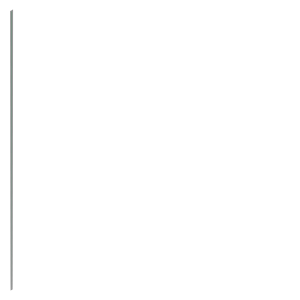

In [141]:
hat